In [16]:
# package imports
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
import cv2
from scipy import signal
from scipy.optimize import curve_fit
import scipy.stats as st
import time
import subprocess as sp
import multiprocessing
import sys
import warnings
from scipy import ndimage
import time
from tqdm import tqdm
import matplotlib as mpl
from astropy.convolution import convolve

# module imports
from util.time import open_time
from util.paths import find
from util.aux_funcs import nanxcorr

In [17]:
# sigmoid function
def curve_func(xval, a, b, c, d):
    return a+(b-a)/(1+10**((c-xval)*d))

# multiprocessing-ready fit to sigmoid function
def sigm_fit_mp(d):
    try:
        popt, pcov = curve_fit(curve_func, xdata=range(1,len(d)+1), ydata=d, p0=[100,200,10,1],
                                bounds=([0, 0, 1, .25],[255, 255, 19, 2]),  method='trf', xtol=10**-3) # cmn - modified , xtol=10**-3
        ci = np.sqrt(np.diagonal(pcov))
    except RuntimeError:
        popt = np.nan*np.zeros(4)
        ci = np.nan*np.zeros(4)
    return (popt, ci)

In [18]:
# cmn modified - changed to only fit 3 parameters
# sigmoid function
def curve_func(xval, a, b, c):
    return a+(b-a)/(1+10**((c-xval)*2))

# multiprocessing-ready fit to sigmoid function
def sigm_fit_mp(d):
    try:
        #popt, pcov = curve_fit(curve_func, xdata=range(1,len(d)+1), ydata=d, p0=[100,200,10],
                               # bounds=([0, 0, 1],[255, 255, 19]),  method='trf', xtol=10**-3) # cmn - modified , xtol=10**-3
        popt, pcov = curve_fit(curve_func, xdata=range(1,len(d)+1), ydata=d, p0=[100.0,200.0,len(d)/2], method='lm', xtol=10**-3, ftol=10**-3) # cmn - modified , xtol=10**-3
#        popt, pcov = curve_fit(curve_func, xdata=range(1,len(d)+1), ydata=d, p0=[0.8*d[0],d[-1]*1.2,len(d)/2], method='lm', xtol=10**-3, ftol=10**-3) # cmn - modified , xtol=10**-3
        ci = np.sqrt(np.diagonal(pcov))
    except RuntimeError:
        popt = np.nan*np.zeros(3)
        ci = np.nan*np.zeros(3)
    return (popt, ci)

In [19]:
cd t:\freely_moving_ephys\ephys_recordings\113020\G6H27P8LT\fm1

t:\freely_moving_ephys\ephys_recordings\113020\G6H27P8LT\fm1


In [20]:
name_base = '113020_G6H27P8LT_control_Rig2_fm1'

eye_file = name_base + 'Reye.nc'
world_file = name_base + '_world.nc'
ephys_file = name_base + '_ephys_merge.json'
imu_file = name_base + "_imu.nc"
speed_file = name_base + "_speed.nc"
eyevidpath = name_base + '_REYEdeinter.avi'

In [21]:
eye_data = xr.open_dataset(eye_file)
eye_ell_params = eye_data['REYE_ellipse_params']

In [22]:
print('found ' + str(multiprocessing.cpu_count()) + ' as cpu count for multiprocessing')

# set up range of degrees in radians
rad_range = np.deg2rad(np.arange(360))



# interpolate ellipse parameters to worldcam timestamps
# eye_ell_interp_params = eye_ell_params.interp_like(xr.DataArray(worldTS), method=world_interp_method)
eye_ell_interp_params = eye_ell_params.copy()

# get the ellipse parameters for this trial from the time-interpolated xarray
eye_theta = eye_ell_interp_params.sel(ellipse_params='theta')
eye_phi = eye_ell_interp_params.sel(ellipse_params='phi')
eye_longaxis= eye_ell_interp_params.sel(ellipse_params='longaxis')
eye_shortaxis = eye_ell_interp_params.sel(ellipse_params='shortaxis')
eye_centX = eye_ell_interp_params.sel(ellipse_params='X0')
eye_centY = eye_ell_interp_params.sel(ellipse_params='Y0')

# set up for the read-in video
eyevid = cv2.VideoCapture(eyevidpath)
totalF = int(eyevid.get(cv2.CAP_PROP_FRAME_COUNT)) # this can be changed to a small number of frames for testing


set_size = (int(eyevid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(eyevid.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# set up for the multiprocessing that'll be used during sigmoid fit function
n_proc = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=n_proc)
n=0

key_error_count = 0



found 12 as cpu count for multiprocessing


(200.0, 400.0)

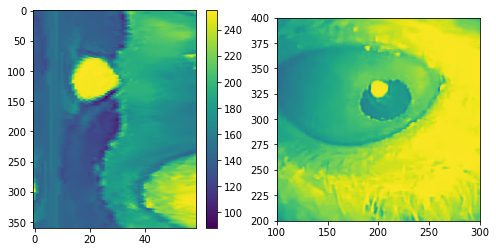

In [23]:
ranger = 30;
step = 1
# frame reading and black and white conversion
eye_ret, eye_frame = eyevid.read()


eye_frame = cv2.cvtColor(eye_frame, cv2.COLOR_BGR2GRAY)

# get ellipse parameters for this time
current_theta = eye_theta.sel(frame=step).values
current_phi = eye_phi.sel(frame=step).values
current_longaxis = eye_longaxis.sel(frame=step).values
current_shortaxis = eye_shortaxis.sel(frame=step).values
current_centX = eye_centX.sel(frame=step).values
current_centY = eye_centY.sel(frame=step).values

# some configuration
meanr = 0.5 * (current_longaxis + current_shortaxis) # mean radius
r = range(int(meanr - ranger), int(meanr + ranger)) # range of values over mean radius (meanr)
pupil_edge = np.zeros([360, len(r)]) # empty array that the calculated edge of the pupil will be put into

rad_range = np.deg2rad(np.arange(360))
# get cross-section of pupil at each angle 1-360 and fit to sigmoid
for i in range(0, len(r)):
    pupil_edge[:,i] = eye_frame[((current_centY + r[i]*(np.sin(rad_range))).astype(int),(current_centX + r[i]*(np.cos(rad_range))).astype(int))]
d = pupil_edge[:,:]

plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.imshow(d, aspect = 'auto'); plt.colorbar()
plt.subplot(1,2,2)
plotrange = np.arange(-100,100)
plt.imshow(eye_frame,vmin=0,vmax=255)
plt.xlim(100,300) ;plt.ylim(200,400)

In [24]:
current_centX

array(206.891583)

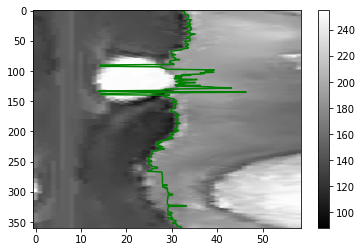

In [25]:
# apply sigmoid fit with multiprocessing
#param_mp = [pool.apply_async(sigm_fit_mp, args=(d[n,:],)) for n in range(360)]
#params_output = [result.get() for result in param_mp]

# apply sigmoid fit without multiprocessing
params_output = []
for n in range(360):
    params_output.append(sigm_fit_mp(d[n,:]))

# unpack outputs of sigmoid fit
params = []; ci = []
for vals in params_output:
    params.append(vals[0])
    ci.append(vals[1])
params = np.stack(params); ci = np.stack(ci)

# extract radius variable from parameters
rfit = params[:,2] - 1
plt.imshow(d, aspect = 'auto', cmap = 'gray')
plt.plot(rfit,range(360),'g')
plt.colorbar()

(0.0, 1.0)

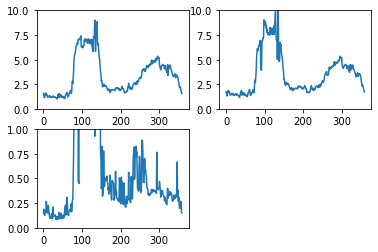

In [26]:
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.plot(ci[:,i])
    plt.ylim(0,10)
plt.subplot(2,2,3)
plt.plot(ci[:,2])
plt.ylim(0,1)


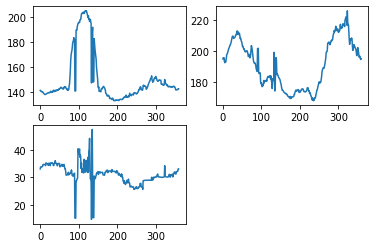

In [27]:
for i in range(3):
    plt.subplot(2,2,i+1)
    plt.plot(params[:,i])


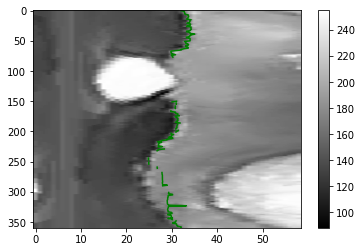

In [28]:


# if confidence interval in estimate is > fit_thresh pix, set to to NaN
ci_temp = (ci[:,0] > 5) | (ci[:,1] > 5)  | (ci[:,2]>0.5)
rfit[ci_temp] = np.nan

# remove if luminance goes the wrong way (e.g. from reflectance)
params_temp1 = (params[:,1] - params[:,0]) < 10
params_temp2 = params[:,1] > 250
rfit[params_temp1] = np.nan
rfit[params_temp2] = np.nan

plt.imshow(d, aspect = 'auto', cmap = 'gray')
plt.plot(rfit,range(360),'g')
plt.colorbar()

<ipython-input-29-9b136fecb286>:13: RuntimeWarning: invalid value encountered in greater
  rfit_conv[np.abs(rfit_conv)>2]=np.nan;


NameError: name 'rfit_conv_xr' is not defined

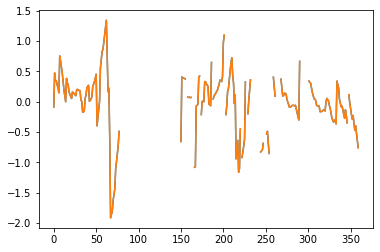

In [29]:
rfit_filt = signal.medfilt(rfit,5)

# subtract baseline because our points aren't perfectly centered on ellipse
filtsize = 31
# rfit_conv = rfit - np.convolve(rfit_interp, np.ones(filtsize)/filtsize, mode='same')
rfit_conv = rfit_filt - convolve(rfit_filt, np.ones(filtsize)/filtsize, boundary='wrap') #cmn modified - changed rfit to rfit_filt
# edges have artifact from conv, so set to NaNs
#   no edge artifacts anymore -- astropy convolve wraps around
# rfit_conv[range(0,int(filtsize/2+1))] = np.nan
# rfit_conv[range((len(rfit_conv)-int(filtsize/2-1)),len(rfit_conv))] = np.nan

plt.plot(rfit_conv)
rfit_conv[np.abs(rfit_conv)>2]=np.nan;
plt.plot(rfit_conv)
    # save out pupil edge data into one xarray for all frames
if step == 0:
    rfit_conv_xr = xr.DataArray(rfit_conv)
    rfit_conv_xr['frame'] = step
    rfit_conv_xr = xr.DataArray.rename(rfit_conv_xr, {'dim_0':'deg'})

    rfit_xr = xr.DataArray(rfit)
    rfit_xr['frame'] = step
    rfit_xr = xr.DataArray.rename(rfit_xr, {'dim_0':'deg'})
if step > 0:
    rfit_conv_temp = xr.DataArray(rfit_conv)
    rfit_conv_temp['frame'] = step
    rfit_conv_temp = xr.DataArray.rename(rfit_conv_temp, {'dim_0':'deg'})
    rfit_conv_xr = xr.concat([rfit_conv_xr, rfit_conv_temp], dim='frame', fill_value=np.nan)

    rfit_temp = xr.DataArray(rfit)
    rfit_temp['frame'] = step
    rfit_temp = xr.DataArray.rename(rfit_temp, {'dim_0':'deg'})
    rfit_xr = xr.concat([rfit_xr, rfit_temp], dim='frame', fill_value=np.nan)

In [30]:
# this section runs all frames in a loop
eyevid = cv2.VideoCapture(eyevidpath)
ranger = 15;  #cmn modified - ranger needs to be >10 for high ellipticity
totalF = 60*300
for step in tqdm(np.arange(totalF)):
    try:
        # frame reading and black and white conversion
        eye_ret, eye_frame = eyevid.read()

        if not eye_ret:
            break

        eye_frame = cv2.cvtColor(eye_frame, cv2.COLOR_BGR2GRAY)

        # get ellipse parameters for this time
        current_theta = eye_theta.sel(frame=step).values
        current_phi = eye_phi.sel(frame=step).values
        current_longaxis = eye_longaxis.sel(frame=step).values
        current_shortaxis = eye_shortaxis.sel(frame=step).values
        current_centX = eye_centX.sel(frame=step).values
        current_centY = eye_centY.sel(frame=step).values

        # some configuration
        meanr = 0.5 * (current_longaxis + current_shortaxis) # mean radius
        r = range(int(meanr - ranger), int(meanr + ranger)) # range of values over mean radius (meanr)
        pupil_edge = np.zeros([360, len(r)]) # empty array that the calculated edge of the pupil will be put into

        rad_range = np.deg2rad(np.arange(360))
        # get cross-section of pupil at each angle 1-360 and fit to sigmoid
        for i in range(0, len(r)):
            pupil_edge[:,i] = eye_frame[((current_centY + r[i]*(np.sin(rad_range))).astype(int),(current_centX + r[i]*(np.cos(rad_range))).astype(int))]
        d = pupil_edge[:,:]

        # apply sigmoid fit with multiprocessing
        #param_mp = [pool.apply_async(sigm_fit_mp, args=(d[n,:],)) for n in range(360)]
        #params_output = [result.get() for result in param_mp]

        # apply sigmoid fit without multiprocessing
        params_output = []
        for n in range(360):
            params_output.append(sigm_fit_mp(d[n,:]))

        # unpack outputs of sigmoid fit
        params = []; ci = []
        for vals in params_output:
            params.append(vals[0])
            ci.append(vals[1])
        params = np.stack(params); ci = np.stack(ci)

        # extract radius variable from parameters
        rfit = params[:,2] - 1

        #cmn modified this section - start
        # if confidence interval in estimate is > fit_thresh pix, set to to NaN
        ci_temp = (ci[:,0] > 5) | (ci[:,1] > 5)  | (ci[:,2]>0.75)
        rfit[ci_temp] = np.nan

        # remove if luminance goes the wrong way (e.g. from reflectance)
        params_temp1 = (params[:,1] - params[:,0]) < 10
        params_temp2 = params[:,1] > 250
        rfit[params_temp1] = np.nan
        rfit[params_temp2] = np.nan
        #cmn modified - end

        try:
            # median filter
            rfit_filt = signal.medfilt(rfit,5) #cmn modified (width =5)

            # subtract baseline because our points aren't perfectly centered on ellipse
            filtsize = 31
            # rfit_conv = rfit - np.convolve(rfit_interp, np.ones(filtsize)/filtsize, mode='same')
            rfit_conv = rfit_filt - convolve(rfit_filt, np.ones(filtsize)/filtsize, boundary='wrap') #cmn modified replace rfit with rfit_filt
            # edges have artifact from conv, so set to NaNs
            #   no edge artifacts anymore -- astropy convolve wraps around
            # rfit_conv[range(0,int(filtsize/2+1))] = np.nan
            # rfit_conv[range((len(rfit_conv)-int(filtsize/2-1)),len(rfit_conv))] = np.nan

        except ValueError as e: # in case every value in rfit is NaN
            rfit_conv = np.nan*np.zeros(360)
    except (KeyError, ValueError) as e:
        key_error_count = key_error_count + 1
        rfit_conv = np.nan*np.zeros(360)
    
    rfit_conv[np.abs(rfit_conv)>1.5]=np.nan;  #cmn modified - get rid of outlier points
    
    # save out pupil edge data into one xarray for all frames
    if step == 0:
        rfit_conv_xr = xr.DataArray(rfit_conv)
        rfit_conv_xr['frame'] = step
        rfit_conv_xr = xr.DataArray.rename(rfit_conv_xr, {'dim_0':'deg'})

        rfit_xr = xr.DataArray(rfit)
        rfit_xr['frame'] = step
        rfit_xr = xr.DataArray.rename(rfit_xr, {'dim_0':'deg'})
    if step > 0:
        rfit_conv_temp = xr.DataArray(rfit_conv)
        rfit_conv_temp['frame'] = step
        rfit_conv_temp = xr.DataArray.rename(rfit_conv_temp, {'dim_0':'deg'})
        rfit_conv_xr = xr.concat([rfit_conv_xr, rfit_conv_temp], dim='frame', fill_value=np.nan)

        rfit_temp = xr.DataArray(rfit)
        rfit_temp['frame'] = step
        rfit_temp = xr.DataArray.rename(rfit_temp, {'dim_0':'deg'})
        rfit_xr = xr.concat([rfit_xr, rfit_temp], dim='frame', fill_value=np.nan)



  0%|                                                                                        | 0/18000 [00:00<?, ?it/s]WARNING: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this. [astropy.convolution.convolve]
<ipython-input-30-98c9e9222e3e>:84: RuntimeWarning: invalid value encountered in greater
  rfit_conv[np.abs(rfit_conv)>1.5]=np.nan;  #cmn modified - get rid of outlier points
100%|██████████████████████████████████████████████████████████████████████████| 18000/18000 [1:34:01<00:00,  3.19it/s]


<Figure size 432x288 with 0 Axes>

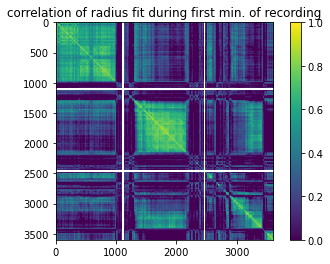

In [31]:

# threshold out any frames with large or small rfit_conv distributions
for frame in range(0,np.size(rfit_conv_xr,0)):
    if np.min(rfit_conv_xr[frame,:]) < -10 or np.max(rfit_conv_xr[frame,:]) > 10:
        rfit_conv_xr[frame,:] = np.nan

# correlation across timepoints
timepoint_corr_rfit = pd.DataFrame(rfit_conv_xr.isel(frame=range(0,np.min([totalF, 3600]))).values).T.corr()

# plot the correlation matrix of rfit over all timepoints

plt.figure()
fig, ax = plt.subplots()
im = ax.imshow(timepoint_corr_rfit,vmin = 0, vmax=1)
ax.set_title('correlation of radius fit during first min. of recording')
#ax.set_xticks(np.arange(len(timepoint_corr_rfit)))
#ax.set_yticks(np.arange(len(timepoint_corr_rfit)))
#ax.set_xticklabels(range(1,len(timepoint_corr_rfit)+1))
#ax.set_yticklabels(range(1,len(timepoint_corr_rfit)+1))
fig.colorbar(im, ax=ax)


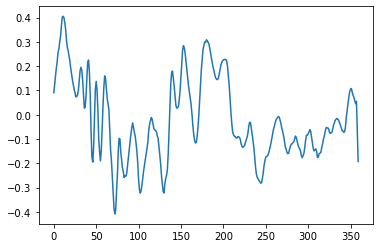

In [32]:
n = np.size(rfit_conv_xr.values, 0)
pupil_update = rfit_conv_xr.values.copy()
total_shift = np.zeros(n); peak = np.zeros(n)
c = total_shift.copy()
template = np.nanmean(rfit_conv_xr.values, 0)
plt.plot(template)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
<ipython-input-33-be12bbca752b>:14: RuntimeWarning: invalid value encountered in greater
  plt.hist(cc_pre[cc_pre>-1], range = (-1,1), bins=40) # gets rid of NaNs in plot


(-1.0, 1.0)

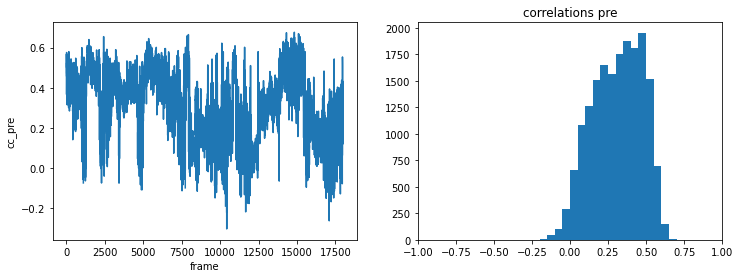

In [33]:
# cmn - new code to see what correlations look like before iterative fit - good for debugging
cc_pre = np.zeros(n);
for frame_num in range(0,n): # do all frames
    try:
        xc, lags = nanxcorr(template, rfit_conv_xr[frame_num], 1)
        cc_pre[frame_num] = xc[1]
    except ZeroDivisionError:
        cc_pre[frame_num] = np.nan;
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(cc_pre); plt.xlabel('frame'); plt.ylabel('cc_pre')
plt.subplot(1,2,2)
plt.title('correlations pre')
plt.hist(cc_pre[cc_pre>-1], range = (-1,1), bins=40) # gets rid of NaNs in plot
plt.xlim(-1,1)


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

doing iterative fit for alignment of each frame


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 25%|████████████████████▊                                                              | 1/4 [02:17<06:51, 137.30s/it]C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 50%|█████████████████████████████████████████▌                                         | 2/4 [04:35<04:35, 137.50s/it]C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [06:54<02:17, 137.91s/it]C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtyp

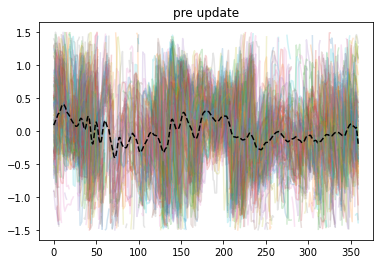

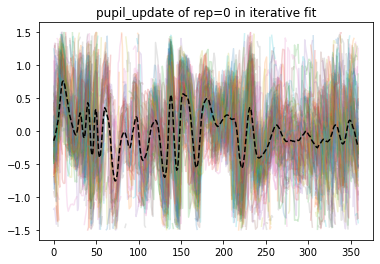

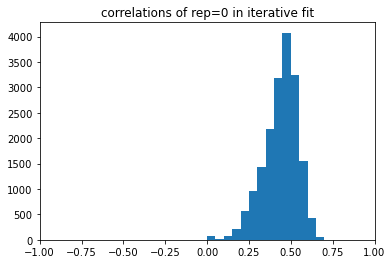

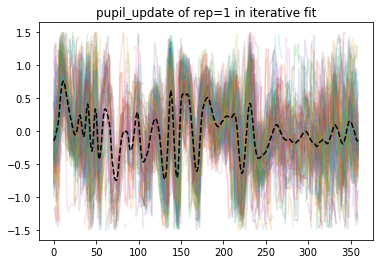

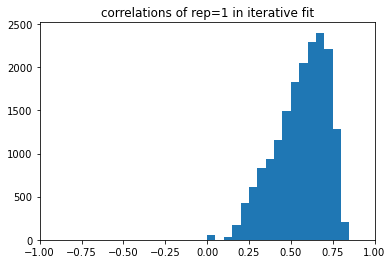

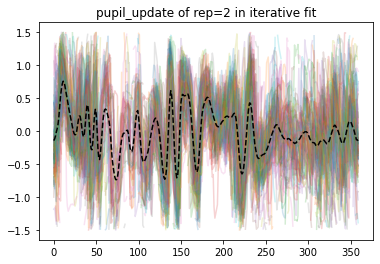

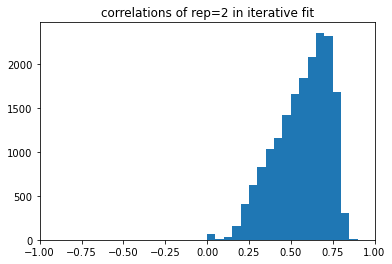

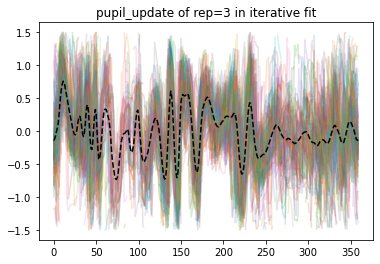

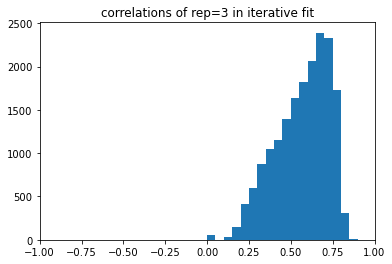

In [34]:
num_rfit_samples_to_plot = 100
ind2plot_rfit = sorted(np.random.randint(0,totalF-1,num_rfit_samples_to_plot))

# iterative fit to alignment
# start with mean as template
# on each iteration, shift individual frames to max xcorr with template
# then recalculate mean template
print('doing iterative fit for alignment of each frame')

# plot template with pupil_update for each iteration of fit
plt.figure()
plt.title('pre update')
plt.plot(pupil_update[ind2plot_rfit,:].T, alpha=0.2)
plt.plot(template, 'k--', alpha=1)
pre_template = template.copy();


for rep in tqdm(range(0,4)): # twelve iterations
    # for each frame, get correlation, and shift
    for frame_num in range(0,n): # do all frames
        try:
            xc, lags = nanxcorr(template, pupil_update[frame_num,:], 20) # cmn - modified to allow 20 lags
            c[frame_num] = np.amax(xc) # value of max
            peaklag = np.argmax(xc) # position of max
            peak[frame_num] = lags[peaklag]
            total_shift[frame_num] = total_shift[frame_num] + peak[frame_num]
            pupil_update[frame_num,:] = np.roll(pupil_update[frame_num,:], int(peak[frame_num]))
        except ZeroDivisionError:
            total_shift[frame_num] = np.nan
            pupil_update[frame_num,:] = np.nan

    
    template = np.nanmean(pupil_update,axis=0)  ### cmn - key update! somehow got dropped
    #plot template with pupil_update for each iteration of fit
    plt.figure()
    plt.title('pupil_update of rep='+str(rep)+' in iterative fit')
    plt.plot(pupil_update[ind2plot_rfit,:].T, alpha=0.2)
    plt.plot(template, 'k--', alpha=1)


    # histogram of correlations
    plt.figure()
    plt.title('correlations of rep='+str(rep)+' in iterative fit')
    plt.hist(c[c>-1], range = (-1,1), bins=40) # gets rid of NaNs in plot
    plt.xlim(-1,1)



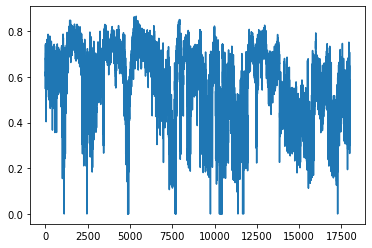

In [35]:
plt.plot(c)

<ipython-input-36-289881c33a07>:7: RuntimeWarning: invalid value encountered in greater_equal
  shift_nan[shift_nan >= 20] = np.nan; shift_nan[shift_nan <= -20] = np.nan # get rid of very large shifts
<ipython-input-36-289881c33a07>:7: RuntimeWarning: invalid value encountered in less_equal
  shift_nan[shift_nan >= 20] = np.nan; shift_nan[shift_nan <= -20] = np.nan # get rid of very large shifts


(-30.0, 30.0)

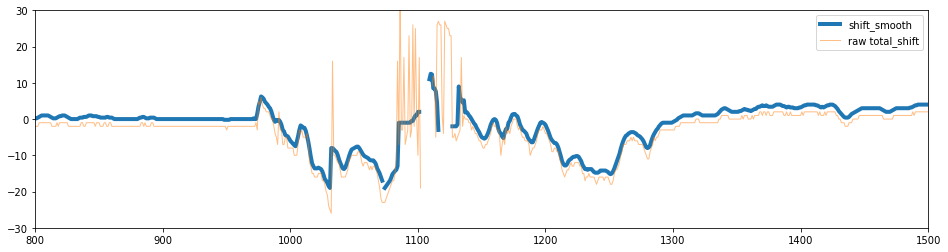

In [36]:
#cmn - significant changes in this section
win = 5
#total_shift = np.deg2rad(total_shift)
shift_nan = -total_shift
shift_nan[c < 0.35] = np.nan # started at [c < 0.4], is it alright to change this? many values go to NaN otherwise; cmn = 0.2 is too low
shift_nan = shift_nan-np.nanmedian(shift_nan);
shift_nan[shift_nan >= 20] = np.nan; shift_nan[shift_nan <= -20] = np.nan # get rid of very large shifts
shift_smooth = signal.medfilt(shift_nan,3)  # median filt to get ride of outliers
shift_smooth = convolve(shift_nan, np.ones(win)/win)  # convolve to smooth and fill in nanas
shift_smooth = shift_smooth - np.nanmedian(shift_smooth)
#shift_nan = shift_nan - np.nanmedian(shift_nan)
plt.figure(figsize = (16,4))
plt.plot(shift_smooth, linewidth = 4, label = 'shift_smooth')
plt.plot(-total_shift,linewidth=1, alpha = 0.5, label = 'raw total_shift')
plt.legend()
#plt.plot(shift_nan, linewidth = 1 )

#plt.plot(shift_nan)
plt.xlim(800,1500)
plt.ylim(-30,30)

Text(0, 0.5, 'final omega - deg')

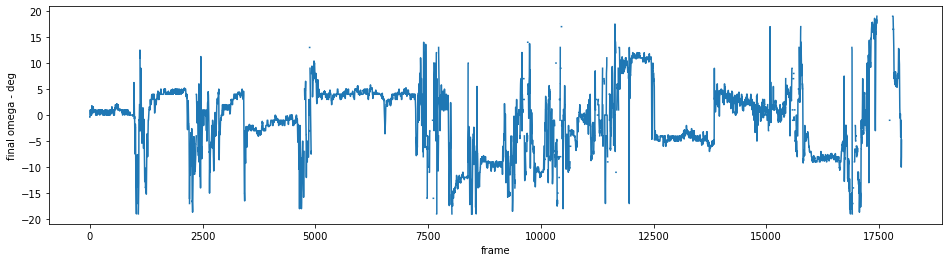

In [37]:
plt.figure(figsize = (16,4))
plt.plot(shift_smooth)
plt.xlabel('frame')
plt.ylabel('final omega - deg')

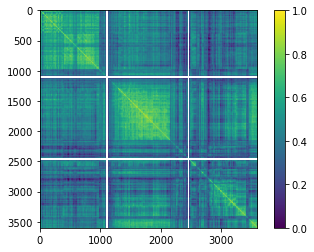

In [38]:
cc = pd.DataFrame(pupil_update[0:np.min([totalF, 3600])]).T.corr()
plt.imshow(cc,vmin = 0, vmax = 1)
plt.colorbar()